# Network Science Project - Analysis of Sports Facilities in Estonia

## Purpose
This notebook presents the analysis conducted as part of a Network Science course project. The primary focus is on data manipulation and network analysis to derive meaningful insights from the dataset.

## Structure
- **Initial Setup**: Import necessary libraries and set up the environment for analysis.
- **Data Loading**: Load two datasets containing data about sports facilities and sports organizations in Estonia.
- **Data Preprocessing**: Convert columns to correct formats, process numerical data, and prepare the data for network analysis.
- **Network Analysis**: Perform network centrality measures, community detection, and identify significant subgraphs. Visualize the results to highlight key facilities and their relationships.

## Goals
- To understand the connections and relationships within the data.
- To apply network science methodologies to uncover patterns and insights.

## Data Sources
- JSON files from Eesti spordiregister (Estonian Sports Register)

## Preprocessing

### Sports Facilities dataset

In [1]:
import json
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pyvis.network import Network
from networkx.algorithms import bipartite
from networkx.algorithms.community import girvan_newman

# Load the JSON data
data = pd.read_json('spordiehitised.json')

# Function to extract information
def extract_info(json_str):
    try:
        # Ensure json_str is a proper JSON string
        if not isinstance(json_str, str):
            json_str = str(json_str)
        json_str = json_str.replace("'", '"').replace('\\', '\\\\')

        # Load JSON data
        data_dict = json.loads(json_str)
        first_key = list(data_dict.keys())[0]
        info = data_dict[first_key]
        
        # Extract required fields
        objektid = info.get('objektid', '')
        objektnimi = info.get('objektnimi', '')
        tehnseisukord = info.get('tehnseisukord', '')
        
        # Extract 'spordialad', handling nested dictionary keys
        spordialad = ', '.join(
            [info['spordialad'][key].get('spordiala', '') for key in info.get('spordialad', {}).keys()]
        )
        
        return pd.Series([objektid, objektnimi, tehnseisukord, spordialad])
    except Exception as e:
        # Log error details
        with open('error_log.txt', 'a') as f:
            f.write(f"Error processing JSON: {e} - Data: {json_str[:100]}\n")
        return pd.Series([None, None, None, None])

# Define new columns and apply the extraction function
new_columns = ['objektid', 'objektnimi', 'tehnseisukord', 'spordialad']
data[new_columns] = data['paigad'].apply(extract_info)

# Keep only necessary columns
columns_to_keep = [
    'rajatisid', 'rajatisnimi', 'kompleks', 'liik', 'omandiliik',
    'om_oigvorm_id', 'omaniknimi', 'omanikregkood', 'va_oigvorm_id',
    'valdajanimi', 'valdajaregkood', 'kaart_laius', 'kaart_pikkus', 'maakond',
    'maakond_kood', 'kov', 'asustusyksus', 'asustusyksus_kood', 'riietusruumidemahutavus',
    'objektid', 'objektnimi', 'tehnseisukord', 'spordialad', 'renoveerimisaasta', 'algusaasta', 'parkimiskohad'
]
data = data[columns_to_keep]

# Save processed data to CSV
data.to_csv('csv_files/facilities.csv', index=False)

# Load processed CSV data
processed_data = pd.read_csv('csv_files/facilities.csv')

# Data cleaning and transformation
processed_data = processed_data.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
processed_data = processed_data.fillna(0)

# Convert specific columns to integers
columns_to_int = [
    'omanikregkood', 'valdajaregkood', 'maakond_kood', 'asustusyksus_kood', 'riietusruumidemahutavus',
    'objektid'
]
for column in columns_to_int:
    processed_data[column] = pd.to_numeric(processed_data[column], errors='coerce').fillna(0).astype(int)

# Save cleaned data again (if needed)
processed_data.to_csv('csv_files/facilities_cleaned.csv', index=False)

### Sports Organisations dataset

In [2]:
# Load the JSON data
with open('spordiorganisatsioonid.json') as f:
    data_org = json.load(f)

# Parse the JSON data to extract relevant information
organizations = []
activity_locations = []
sports = []

for item in data_org:
    org_id = item['org_id']
    org_name = item['nimi']
    registrikood = item['registrikood']
    maakond = item['maakond']
    maakond_kood = item['maakond_kood']
    kov = item['kov']
    kov_kood = item['kov_kood']
    kaart_laius = item['kaart_laius']
    kaart_pikkus = item['kaart_pikkus']
    
    sports_list = []
    if 'sport' in item:
        for sport in item['sport'].values():
            sports_list.append(sport['spordiala'])
            if 'tegutsemispaigad' in sport and isinstance(sport['tegutsemispaigad'], dict):
                for location_key, location in sport['tegutsemispaigad'].items():
                    activity_locations.append({
                        'org_id': org_id,
                        'location_name': location['nimi'],
                        'location_address': location['aadress']
                    })
            sports.append(sport['spordiala'])

    organizations.append({
        'org_id': org_id,
        'nimi': org_name,
        'registrikood': registrikood,
        'maakond': maakond,
        'maakond_kood': maakond_kood,
        'kov': kov,
        'kov_kood': kov_kood,
        'kaart_laius': kaart_laius,
        'kaart_pikkus': kaart_pikkus,
        'sports': ', '.join(sports_list)  # Combine sports into a single string
    })

# Convert to DataFrame
df_organizations = pd.DataFrame(organizations)
df_activity_locations = pd.DataFrame(activity_locations)

# Merge activity locations with organizations
df_merged = pd.merge(df_organizations, df_activity_locations, on='org_id', how='left')

# Convert all string columns to lowercase
processed_data_org = df_merged.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
# Fill NaN values with '0'
#processed_data_org = processed_data_org.fillna(0)

# Convert columns to appropriate types
for column in processed_data_org.columns:
    if processed_data_org[column].dtype == 'object':
        processed_data_org[column] = processed_data_org[column].astype(str)

columns_to_int_org = ['registrikood', 'maakond_kood', 'kov_kood']
for column in columns_to_int_org:
    processed_data_org[column] = pd.to_numeric(processed_data_org[column], errors='coerce').fillna(0).astype(int)

processed_data_org = processed_data_org[(processed_data_org['location_name'].notna()) & (processed_data_org['location_name'] != '0')]

# Save the processed data
processed_data_org.to_csv('csv_files/organizations.csv', index=False)

#### (Optional) Filter out a specific sports and/or condition of the facility

In [3]:
### CHOOSE SPORTS
filtered_data_org = processed_data_org
filtered_data_fac = processed_data

# sports = 'jalgpall'
# #condition = 'väga hea'


# # Filter processed_data_org where 'sports' contains 'jalgpall'
# filtered_data_org = filtered_data_org[filtered_data_org['sports'].str.contains(sports, case=False, na=False)]

# # Filter processed_data where 'spordialad' contains 'jalgpall'
# filtered_data_fac = processed_data[
#     processed_data['spordialad'].str.contains(sports, case=False, na=False) #& 
#     #processed_data['tehnseisukord'].str.contains(condition, case=False, na=False)
# ]

# Load and display the first few rows of each filtered dataset to verify
filtered_data_org.head(), filtered_data_fac.head()

(  org_id                           nimi  registrikood   maakond  maakond_kood  \
 0   7065            #26 racing team mtü      80580106  harjumaa            37   
 1   5948  #teampinkpurple disc golf mtü      80409045   hiiumaa            39   
 2   5403                   & moments oü      11675818  harjumaa            37   
 3   7258            24-7fitnessklubi oü      14045006  harjumaa            37   
 4   7258            24-7fitnessklubi oü      14045006  harjumaa            37   
 
        kov  kov_kood      kaart_laius     kaart_pikkus  \
 0     kose       338  59.200119943764   25.10618680465   
 1  hiiumaa       205  58.999830604063  22.729827811749   
 2  tallinn       784                                     
 3  tallinn       784  59.411224815176  24.671721206262   
 4  tallinn       784  59.411224815176  24.671721206262   
 
                              sports  \
 0                                     
 1                  lennuketta sport   
 2                            

In [4]:
# Filter out facilities that do not have "kaart" in their name
filtered_data_fac = filtered_data_fac[~filtered_data_fac['rajatisnimi'].str.contains('kaart', case=False, na=False)]

# Save the updated DataFrame to a new CSV file
filtered_data_fac.to_csv('csv_files/filtered_facilities.csv', index=False)

# Print the updated DataFrame to verify
print(filtered_data_fac.head())
print(f"Number of facilities after removal: {filtered_data_fac.shape[0]}")

   rajatisid             rajatisnimi kompleks                            liik  \
0       5221      24-7 fitness pärnu        0  võimla, spordihall, spordisaal   
1       5585       24-7fitness avala        0  võimla, spordihall, spordisaal   
2       4910  24-7fitness kuressaare        0  võimla, spordihall, spordisaal   
3       4890        24-7fitness laki        0  võimla, spordihall, spordisaal   
4       6072       24-7fitness luige        0  võimla, spordihall, spordisaal   

  omandiliik om_oigvorm_id                     omaniknimi  omanikregkood  \
0  kinnisasi      osaühing               oü triple invest       10250206   
1  kinnisasi   aktsiaselts  aktsiaselts kaamos kinnisvara       10886401   
2  kinnisasi      osaühing                oü tulik invest       11449200   
3  kinnisasi      osaühing                 laki põik 4 oü       12943304   
4  kinnisasi      osaühing             luige ärikeskus oü       16335062   

  va_oigvorm_id          valdajanimi  ...        asustus

## Network construction

In [5]:
# Replace '0' in 'algusaasta' with the mean of non-zero values
mean_algusaasta = filtered_data_fac.loc[filtered_data_fac['algusaasta'] != 0, 'algusaasta'].mean()
filtered_data_fac.loc[:, 'algusaasta'] = filtered_data_fac['algusaasta'].replace(0, mean_algusaasta)

# Replace '0' in 'renoveerimisaasta' with the corresponding value in 'algusaasta'
filtered_data_fac.loc[:, 'renoveerimisaasta'] = filtered_data_fac.apply(
    lambda row: row['algusaasta'] if row['renoveerimisaasta'] == 0 else row['renoveerimisaasta'], axis=1
)

# Ensure no facility with ID 0 is present
filtered_data_fac = filtered_data_fac[filtered_data_fac['objektid'] != 0]

# Normalize facility attributes
def normalize(data):
    min_val = min(data)
    max_val = max(data)
    if max_val == min_val:
        return [0] * len(data)
    return [(x - min_val) / (max_val - min_val) for x in data]

filtered_data_fac['normalized_lockers'] = normalize(filtered_data_fac['riietusruumidemahutavus'].tolist())
filtered_data_fac['normalized_parking'] = normalize(filtered_data_fac['parkimiskohad'].tolist())
filtered_data_fac['normalized_renovation'] = normalize(filtered_data_fac['renoveerimisaasta'].tolist())
filtered_data_fac['normalized_start'] = normalize(filtered_data_fac['algusaasta'].tolist())

# Replace '0' with 'teadmata' in 'tehnseisukord'
filtered_data_fac['tehnseisukord'] = filtered_data_fac['tehnseisukord'].replace(0, 'teadmata')

# Normalize condition with the given categories
condition_map = {
    'väga hea': 1,
    'hea': 0.8,
    'rahuldav': 0.6,
    'mitterahuldav': 0.4,
    'kasutuskõlbmatu': 0.2,
    'teadmata': 0
}
filtered_data_fac['normalized_condition'] = normalize([condition_map[condition] for condition in filtered_data_fac['tehnseisukord'].tolist()])

# Define weights
weights = {
    'lockers': 0.3,
    'parking': 0.05,
    'renovation': 0.15,
    'start': 0.1,
    'condition': 0.4
}

# Calculate facilities_scores
filtered_data_fac['facilities_scores'] = (
    filtered_data_fac['normalized_lockers'] * weights['lockers'] +
    filtered_data_fac['normalized_parking'] * weights['parking'] +
    filtered_data_fac['normalized_renovation'] * weights['renovation'] +
    filtered_data_fac['normalized_start'] * weights['start'] +
    filtered_data_fac['normalized_condition'] * weights['condition']
)

# Save the updated DataFrame to a new CSV file
filtered_data_fac.to_csv('csv_files/facilities_with_scores.csv', index=False)

# Print the updated DataFrame to verify
print(filtered_data_fac.head())

   rajatisid             rajatisnimi kompleks                            liik  \
0       5221      24-7 fitness pärnu        0  võimla, spordihall, spordisaal   
1       5585       24-7fitness avala        0  võimla, spordihall, spordisaal   
2       4910  24-7fitness kuressaare        0  võimla, spordihall, spordisaal   
3       4890        24-7fitness laki        0  võimla, spordihall, spordisaal   
4       6072       24-7fitness luige        0  võimla, spordihall, spordisaal   

  omandiliik om_oigvorm_id                     omaniknimi  omanikregkood  \
0  kinnisasi      osaühing               oü triple invest       10250206   
1  kinnisasi   aktsiaselts  aktsiaselts kaamos kinnisvara       10886401   
2  kinnisasi      osaühing                oü tulik invest       11449200   
3  kinnisasi      osaühing                 laki põik 4 oü       12943304   
4  kinnisasi      osaühing             luige ärikeskus oü       16335062   

  va_oigvorm_id          valdajanimi  ...  \
0      osaü

The graph is bipartite.
Number of nodes: 6527
Number of edges: 4189


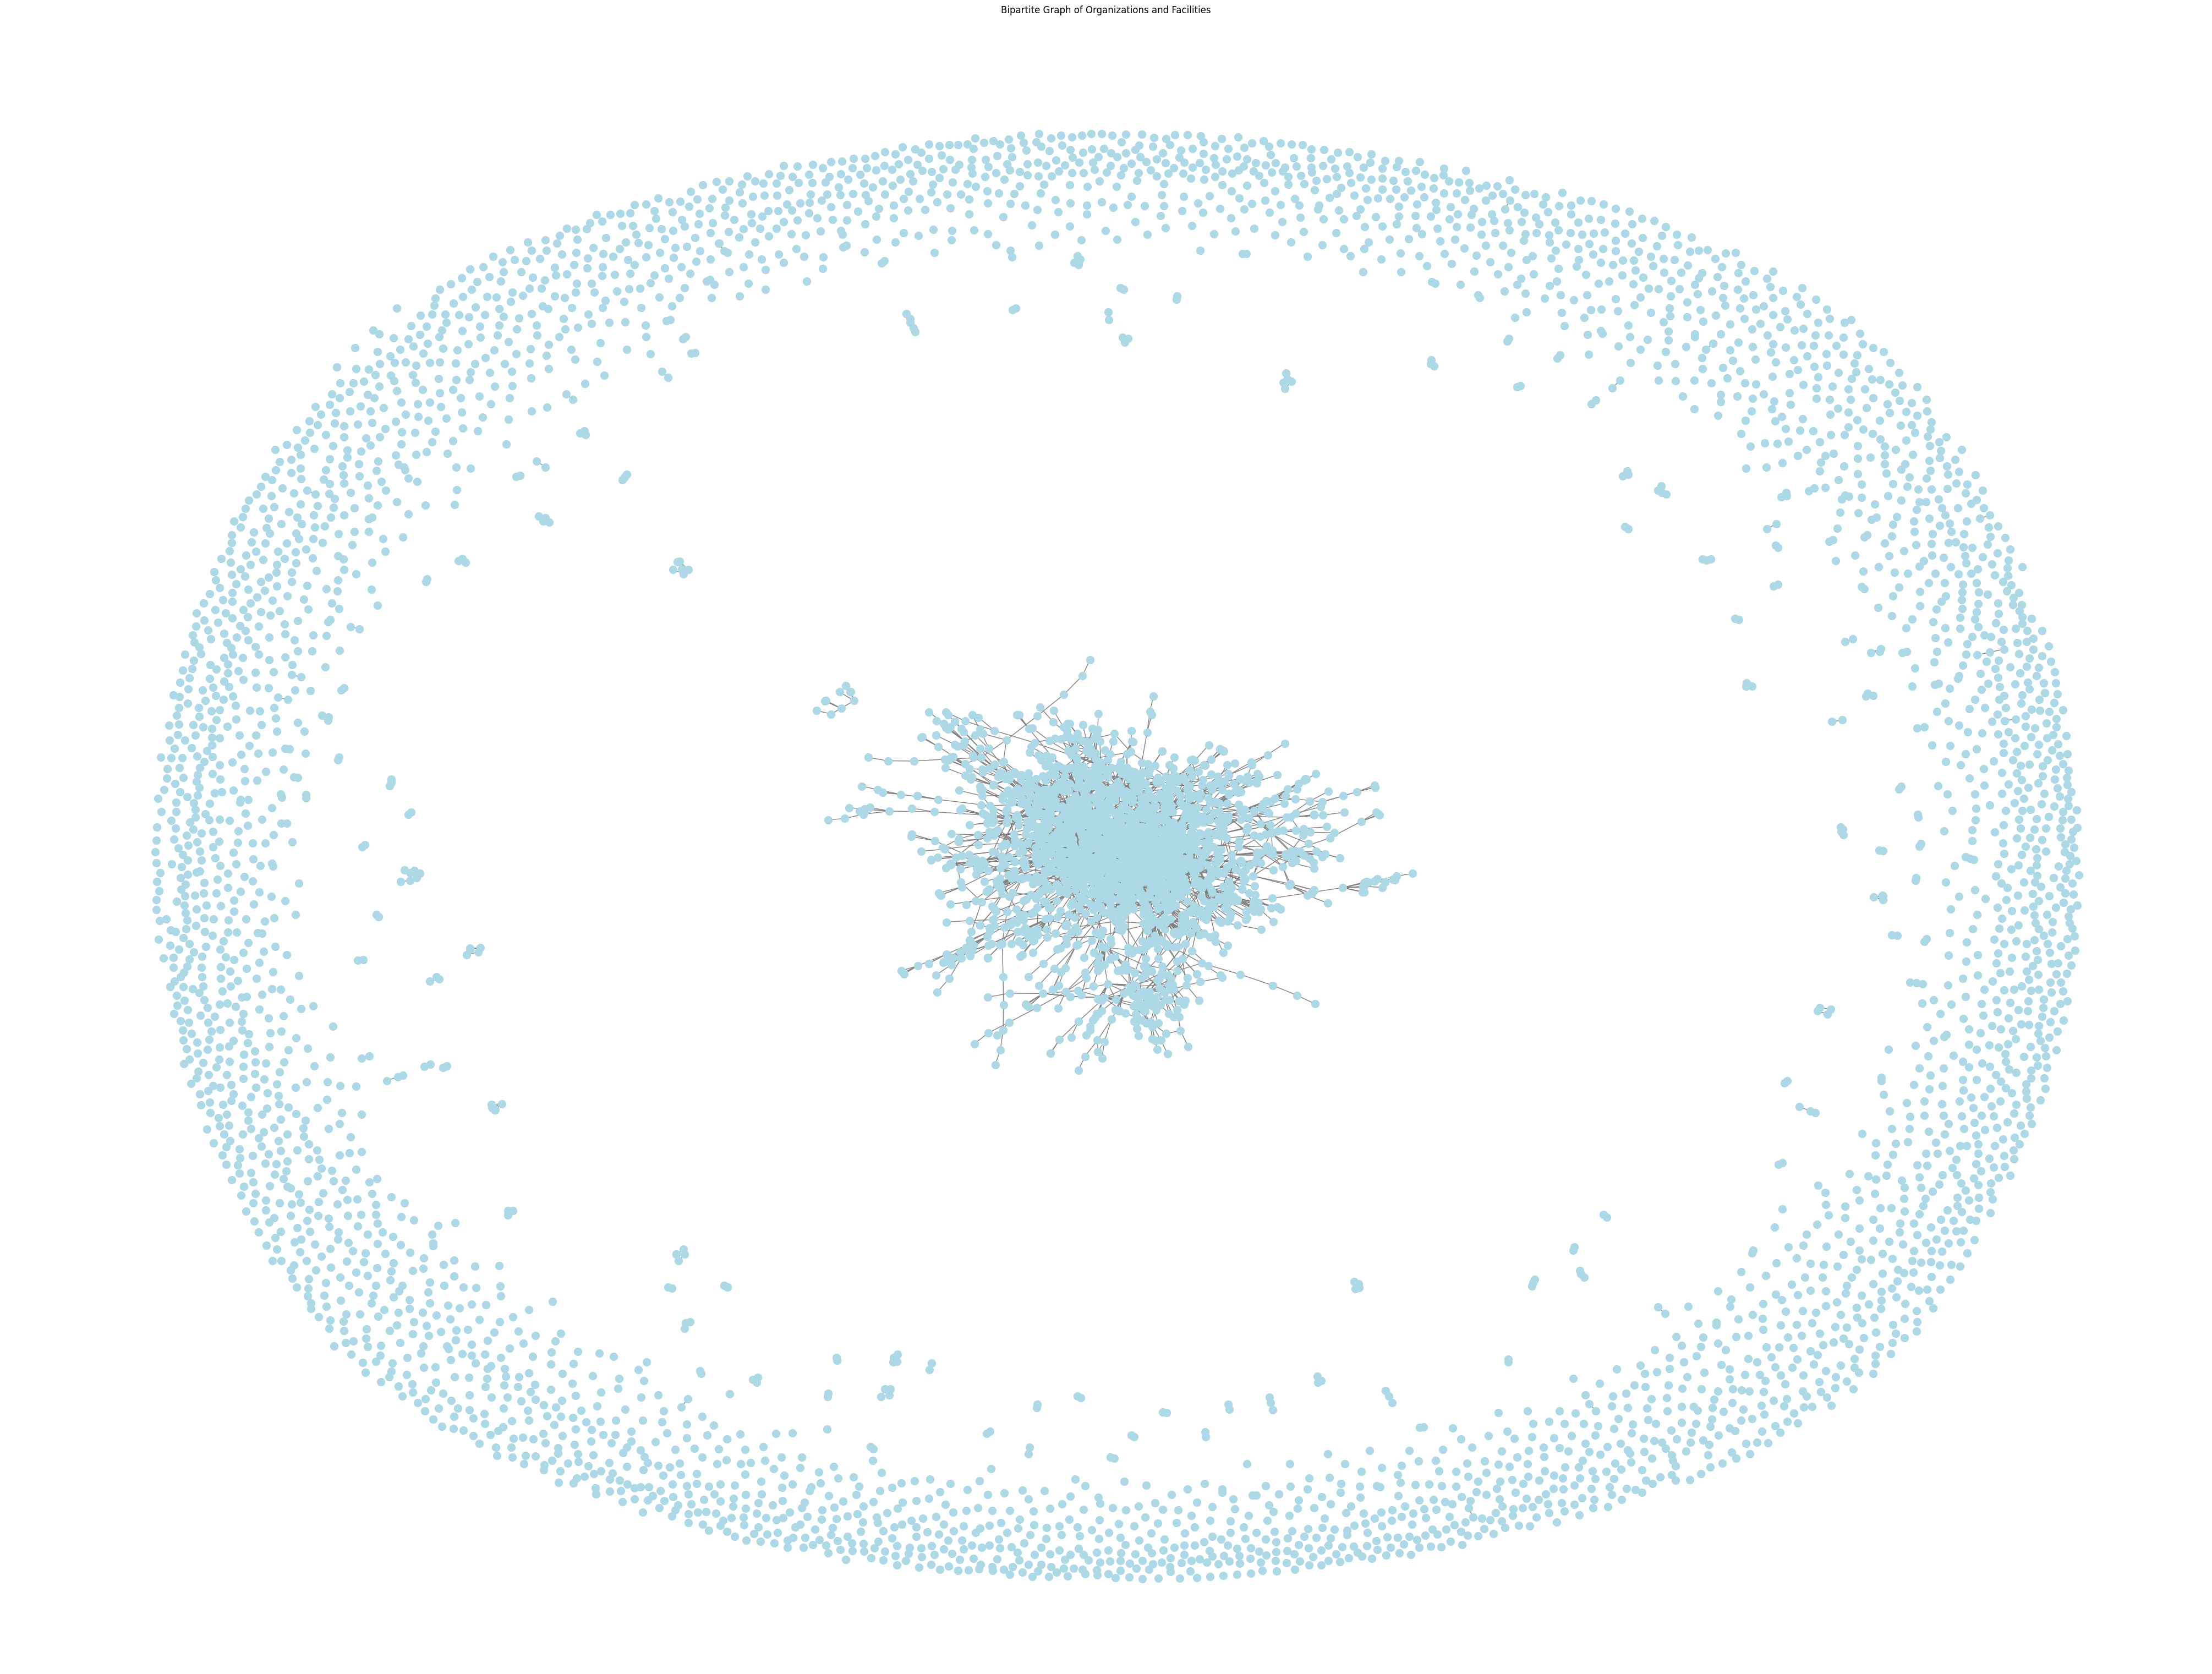

In [6]:
# Create a bipartite graph
B = nx.Graph()

# Add nodes for facilities
for index, row in filtered_data_fac.iterrows():
    B.add_node(row['objektid'], bipartite=0, label=row['rajatisnimi'], lockers=row['riietusruumidemahutavus'], 
               parking=row['parkimiskohad'], renovation=row['renoveerimisaasta'], start=row['algusaasta'],
               condition=row['tehnseisukord'], score=row['facilities_scores'])

# Add nodes for organizations
for index, row in filtered_data_org.iterrows():
    B.add_node(row['org_id'], bipartite=1, label=row['nimi'])

# Add edges
for index, row in filtered_data_org.iterrows():
    if pd.notna(row['location_name']):
        facility_ids = filtered_data_fac[filtered_data_fac['rajatisnimi'] == row['location_name']]['objektid'].values
        for facility_id in facility_ids:
            B.add_edge(row['org_id'], facility_id)

# Save the updated DataFrame to a new CSV file
filtered_data_fac.to_csv('csv_files/facilities_with_scores.csv', index=False)

# Validate the bipartite nature
if bipartite.is_bipartite(B):
    print("The graph is bipartite.")
else:
    print("The graph is not bipartite. Checking for issues...")

# Print number of nodes and edges
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")

# Visualizing the bipartite graph
plt.figure(figsize=(40, 30))
pos = nx.spring_layout(B, seed=42)
nx.draw(B, pos, with_labels=False, node_size=100, font_size=6, node_color='lightblue', edge_color='gray')
plt.title("Bipartite Graph of Organizations and Facilities")
plt.show()

In [7]:
# Find facility nodes with 0 edges
facility_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 0]
facility_nodes_with_zero_edges = [node for node in facility_nodes if B.degree(node) == 0]

# Count the number of such facility nodes
count_facility_nodes_with_zero_edges = len(facility_nodes_with_zero_edges)

# List the labels (names) of these facility nodes
labels_facility_nodes_with_zero_edges = [B.nodes[node]['label'] for node in facility_nodes_with_zero_edges]

# Print the count and the list of names
print(f"Number of facility nodes with 0 edges: {count_facility_nodes_with_zero_edges}")

Number of facility nodes with 0 edges: 2141


In [8]:
# Calculate the degree (number of edges) for each facility node
facility_degrees = [(node, B.degree(node)) for node, data in B.nodes(data=True) if data['bipartite'] == 0]

# Sort the facility nodes by their degree in descending order
facility_degrees_sorted = sorted(facility_degrees, key=lambda x: x[1], reverse=True)

# Calculate the total number of edges in the graph
total_edges = B.number_of_edges()

# Calculate the cumulative sum of edges to find the point where it reaches 90%
cumulative_edges = 0
facilities_count = 0
for node, degree in facility_degrees_sorted:
    cumulative_edges += degree
    facilities_count += 1
    if cumulative_edges >= 0.9 * total_edges:
        break

# Print the number of facilities that together have 90% of all the edges
print(f"Number of facilities that together have 90% of all the edges: {facilities_count}")

Number of facilities that together have 90% of all the edges: 971


In [9]:
# Continue visualizing in Gephi
# nx.write_graphml(B, "gephi/NAME_OF_THE_FILE_GOES_HERE.graphml")

## Network Analysis

### Degree and betweenness centrality

In [10]:
# Calculate centrality measures
facility_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}

# Calculate bipartite degree centrality for facilities
degree_centrality = nx.bipartite.degree_centrality(B, facility_nodes)

# Calculate bipartite betweenness centrality for facilities
betweenness_centrality = nx.bipartite.betweenness_centrality(B, facility_nodes)

# Calculate bipartite closeness centrality for facilities
closeness_centrality = nx.bipartite.closeness_centrality(B, facility_nodes)

# Convert the results to a DataFrame with facility names
centrality_df = pd.DataFrame({
    'facility': [B.nodes[n]['label'] for n in facility_nodes],
    'degree_centrality': [degree_centrality[n] for n in facility_nodes],
    'betweenness_centrality': [betweenness_centrality[n] for n in facility_nodes],
    'closeness_centrality': [closeness_centrality[n] for n in facility_nodes]
})

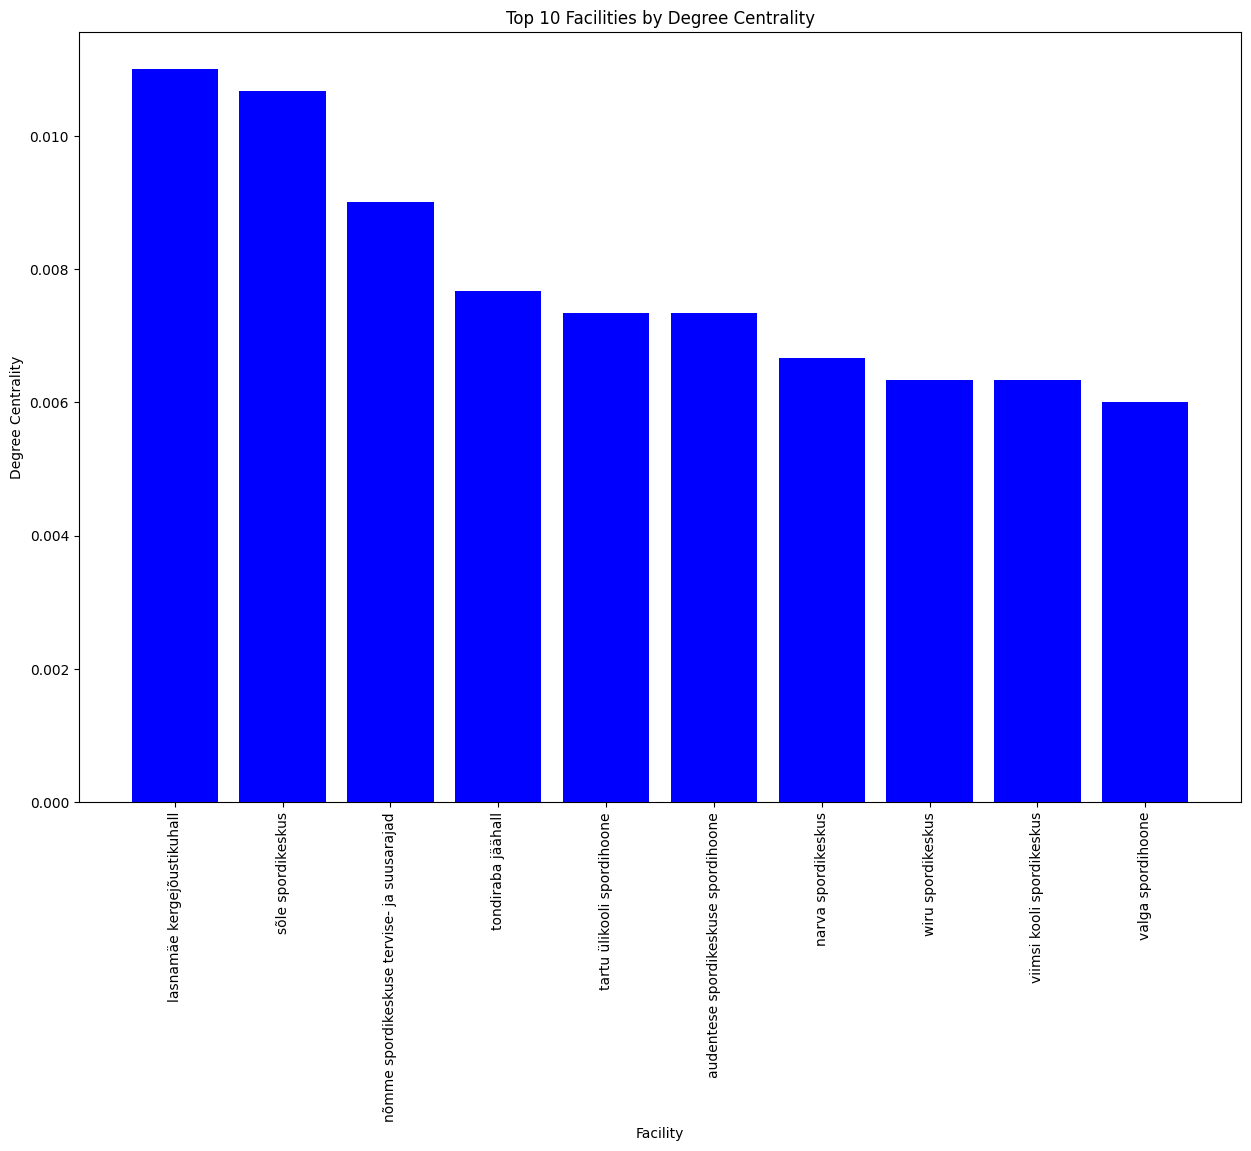

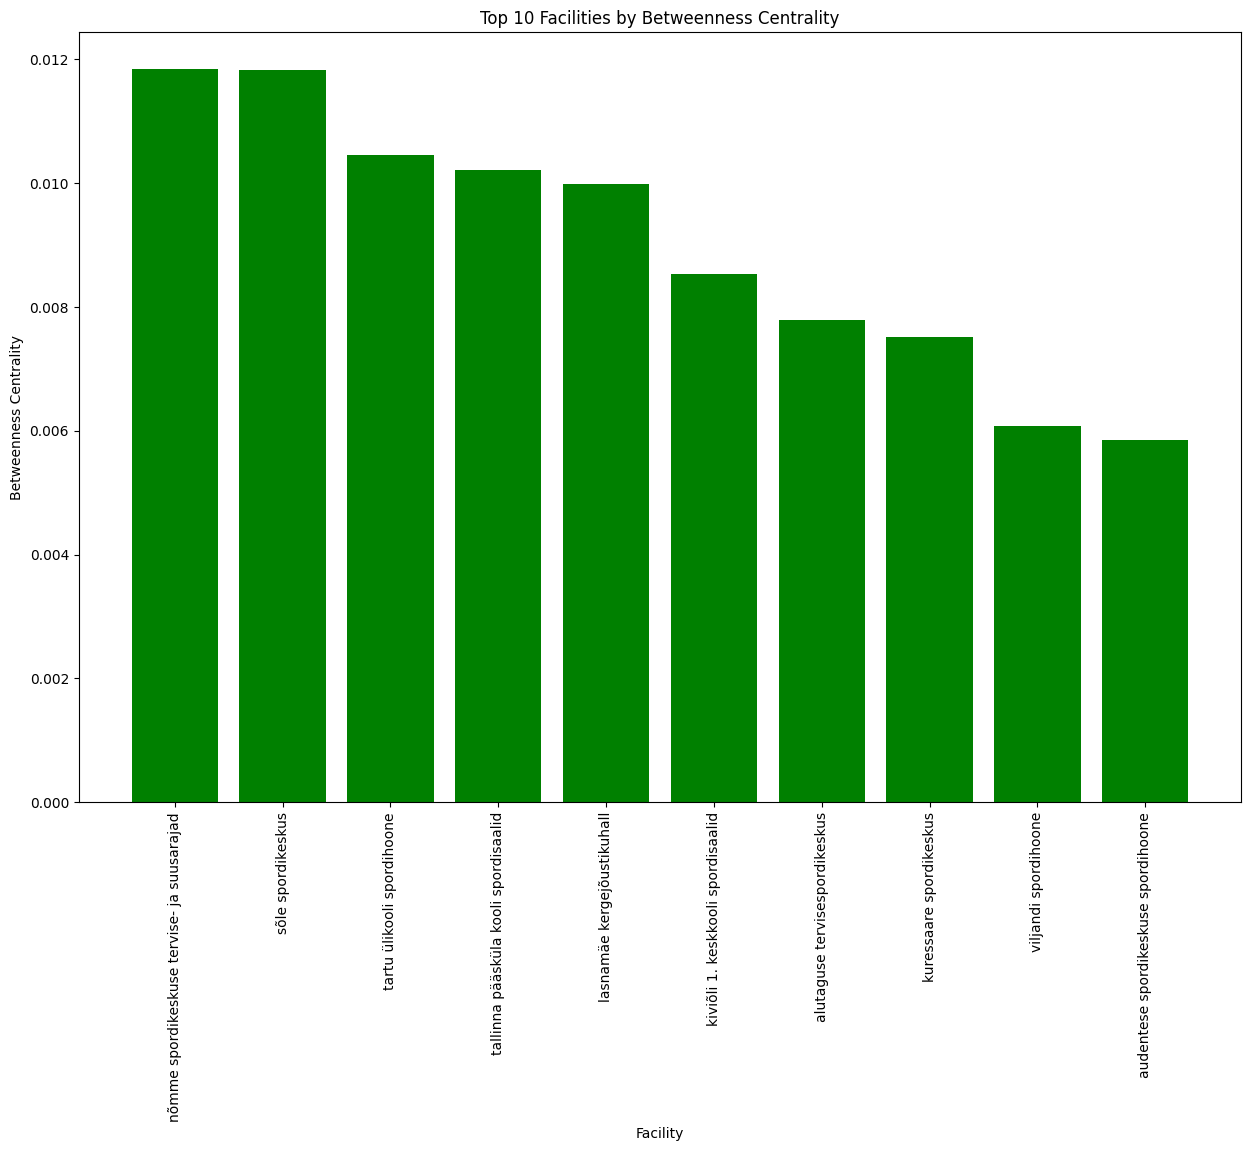

In [11]:
# Sort the DataFrame by degree centrality to find the most connected facilities
centrality_df = centrality_df.sort_values(by='degree_centrality', ascending=False)

# Plot Degree Centrality for visualization
plt.figure(figsize=(15, 10))
plt.bar(centrality_df['facility'][:10], centrality_df['degree_centrality'][:10], color='blue')
plt.xlabel('Facility')
plt.ylabel('Degree Centrality')
plt.title('Top 10 Facilities by Degree Centrality')
plt.xticks(rotation=90)
plt.show()

# Sort the DataFrame by betweenness centrality
centrality_df = centrality_df.sort_values(by='betweenness_centrality', ascending=False)

# Plot Betweenness Centrality for visualization
plt.figure(figsize=(15, 10))
plt.bar(centrality_df['facility'][:10], centrality_df['betweenness_centrality'][:10], color='green')
plt.xlabel('Facility')
plt.ylabel('Betweenness Centrality')
plt.title('Top 10 Facilities by Betweenness Centrality')
plt.xticks(rotation=90)
plt.show()


In [12]:
# Sort the DataFrame by degree centrality to find the most connected facilities
top_10_facilities = centrality_df.sort_values(by='degree_centrality', ascending=False).head(10)

# Print the top 10 facilities with their degree centrality and betweenness centrality
print("Top 10 Facilities by Degree Centrality:")
print(top_10_facilities[['facility', 'degree_centrality', 'betweenness_centrality']])

Top 10 Facilities by Degree Centrality:
                                        facility  degree_centrality  \
790                   lasnamäe kergejõustikuhall           0.011011   
411                            sõle spordikeskus           0.010677   
2414  nõmme spordikeskuse tervise- ja suusarajad           0.009009   
3197                           tondiraba jäähall           0.007674   
1306                  tartu ülikooli spordihoone           0.007341   
361          audentese spordikeskuse spordihoone           0.007341   
2124                          narva spordikeskus           0.006673   
800                    viimsi kooli spordikeskus           0.006340   
1796                           wiru spordikeskus           0.006340   
2893                           valga spordihoone           0.006006   

      betweenness_centrality  
790                 0.009982  
411                 0.011823  
2414                0.011849  
3197                0.002077  
1306                0.0

In [13]:
# Find nodes with zero degree centrality
zero_degree_centrality_nodes = centrality_df[centrality_df['degree_centrality'] == 0]
num_zero_degree_centrality_nodes = len(zero_degree_centrality_nodes)

# Calculate mean and median of degree centrality
mean_degree_centrality = centrality_df['degree_centrality'].mean()
median_degree_centrality = centrality_df['degree_centrality'].median()

print(f"Number of nodes with zero degree centrality: {num_zero_degree_centrality_nodes}")
print(f"Mean degree centrality: {mean_degree_centrality}")
print(f"Median degree centrality: {median_degree_centrality}")

Number of nodes with zero degree centrality: 2141
Mean degree centrality: 0.0003959578086112552
Median degree centrality: 0.0


### Top components

Number of nodes in top 10 components: 2623
Number of edges in top 10 components: 3971


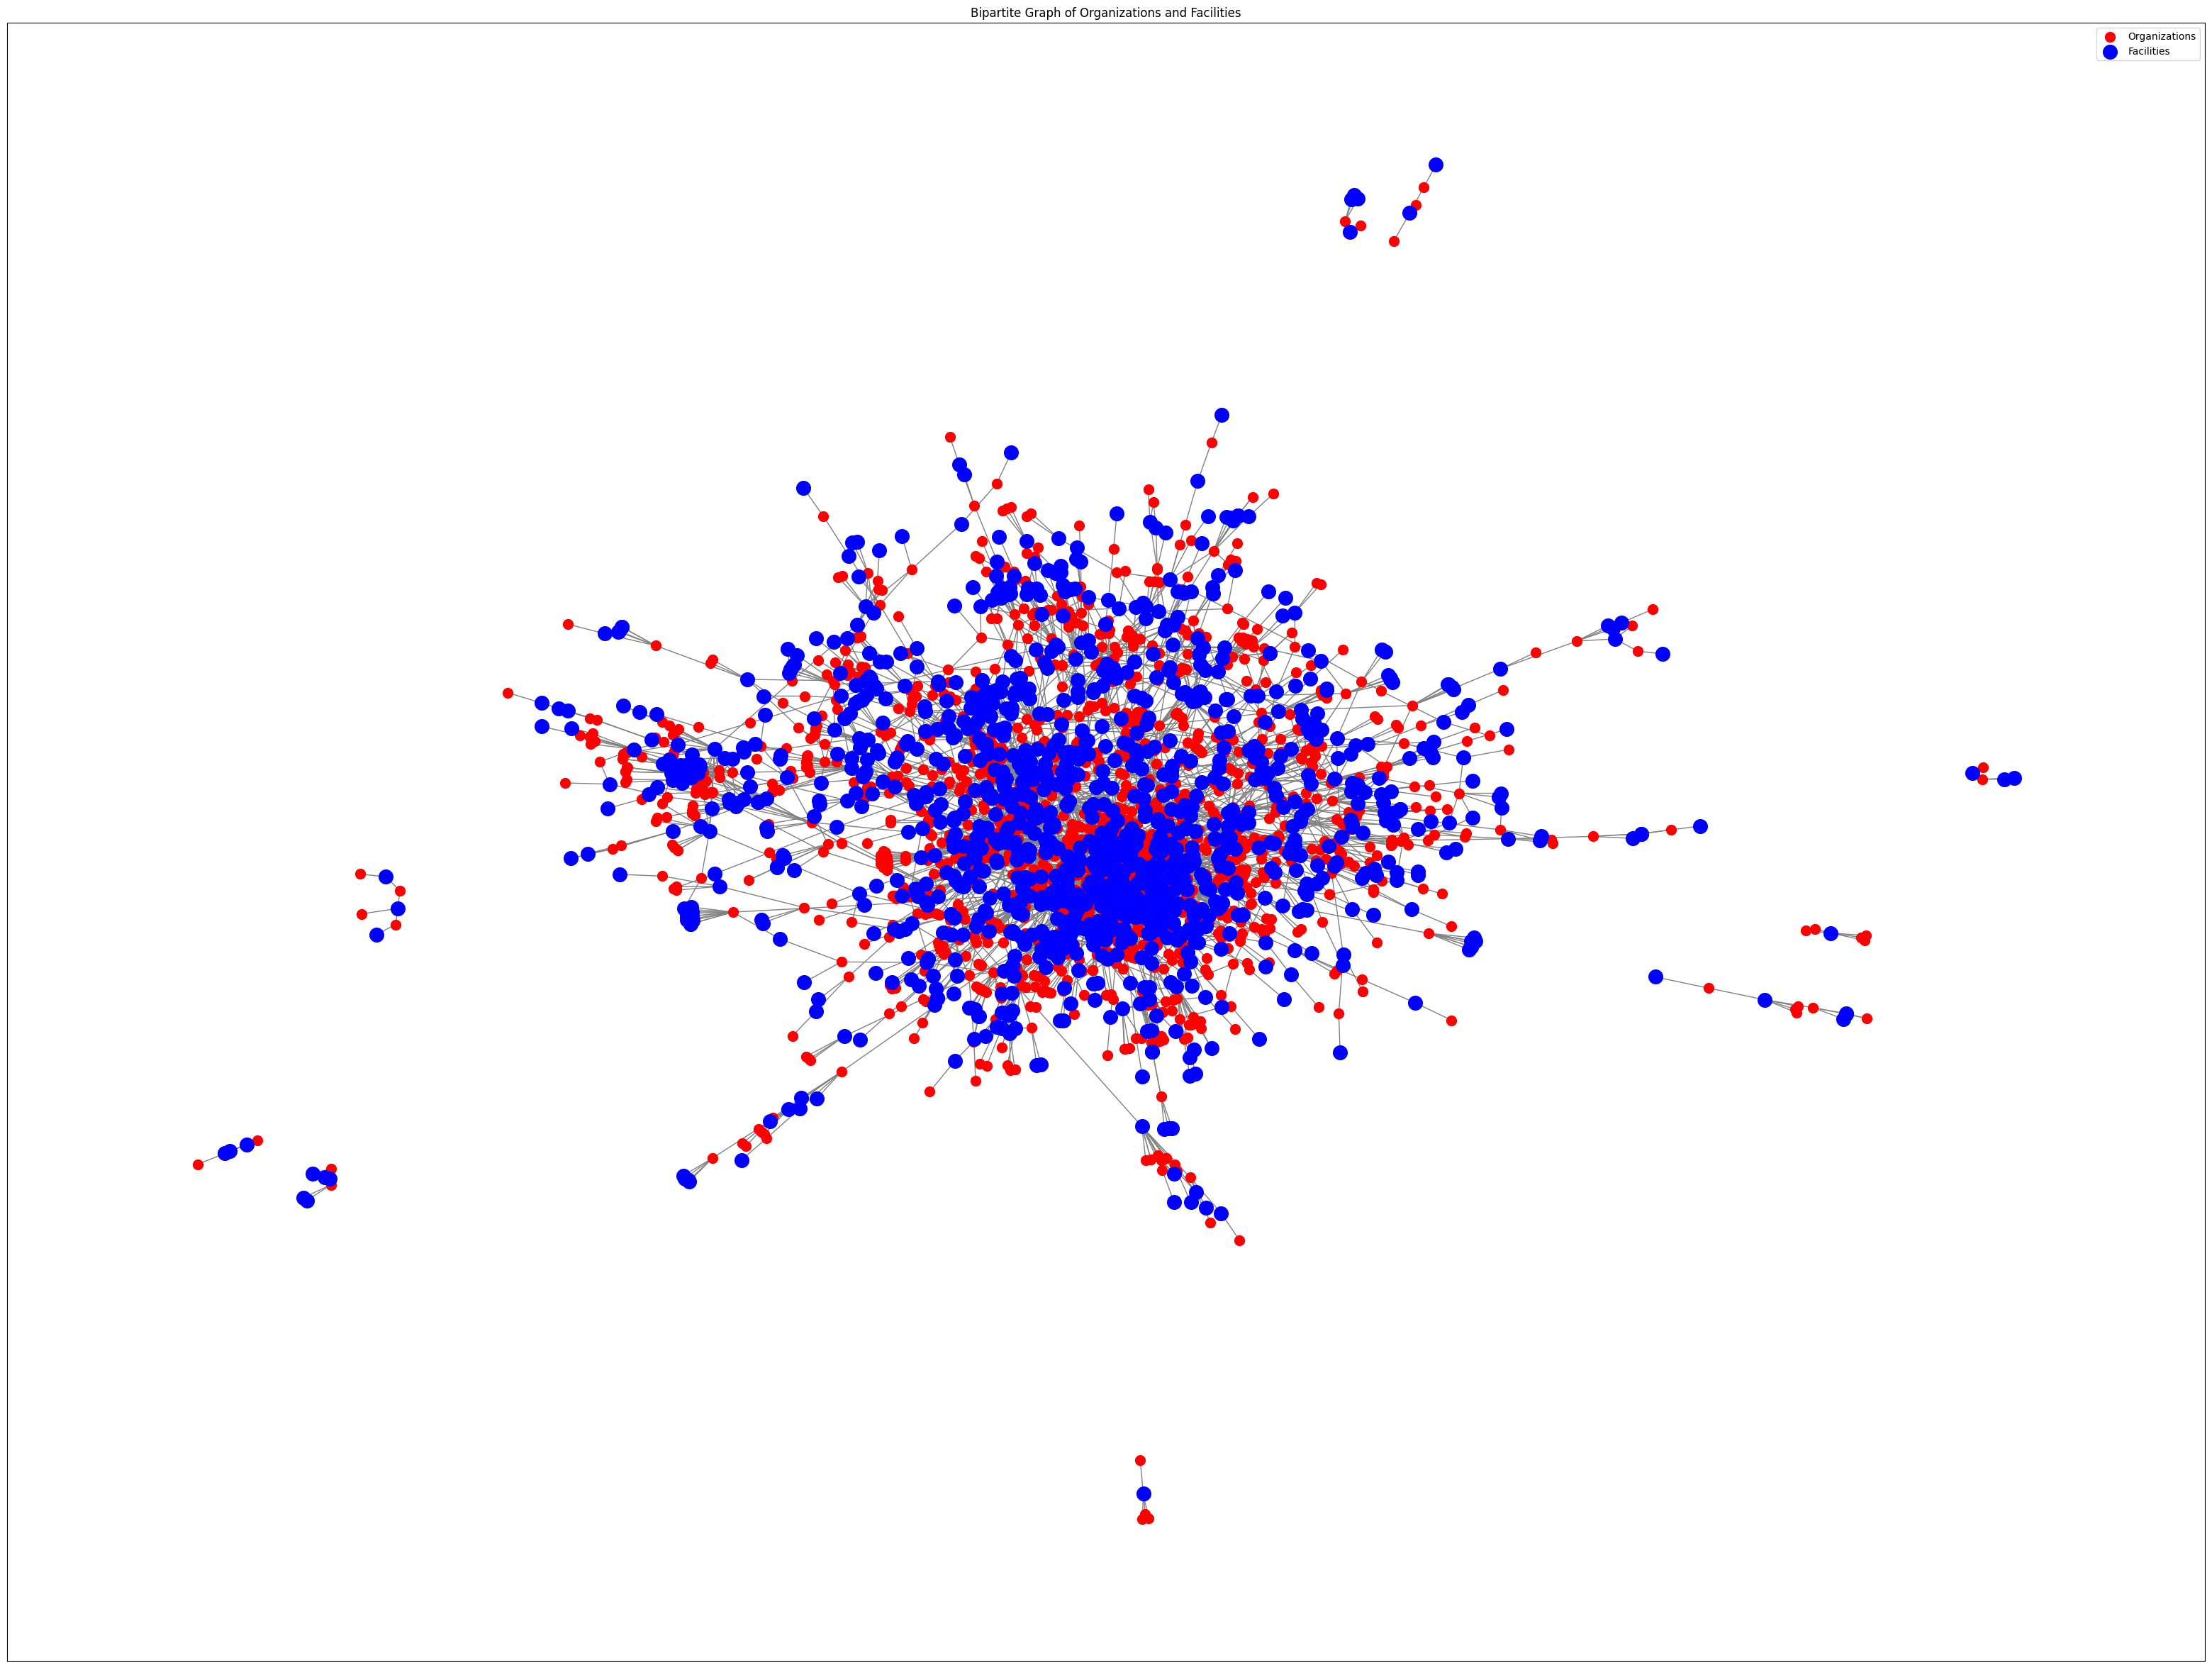

In [14]:
components = list(nx.connected_components(B))
sorted_components = sorted(components, key=len, reverse=True)

# Select the top 10 largest components
top_components = sorted_components[:10]

# Create subgraphs for the top 10 largest components
subgraphs = [B.subgraph(component) for component in top_components]

# Combine all subgraphs into one plot
combined_subgraph = nx.Graph()

# Add nodes and edges from each subgraph to the combined graph
for subgraph in subgraphs:
    combined_subgraph.add_nodes_from(subgraph.nodes(data=True))
    combined_subgraph.add_edges_from(subgraph.edges(data=True))

# Print number of nodes and edges
print(f"Number of nodes in top 10 components: {combined_subgraph.number_of_nodes()}")
print(f"Number of edges in top 10 components: {combined_subgraph.number_of_edges()}")

# Visualize the bipartite graph with labels
plt.figure(figsize=(40, 30))
pos = nx.spring_layout(combined_subgraph, seed=42)

# Draw nodes
org_nodes = {n for n, d in combined_subgraph.nodes(data=True) if d.get('bipartite') == 1}
facility_nodes = set(combined_subgraph) - org_nodes

nx.draw_networkx_nodes(combined_subgraph, pos, nodelist=org_nodes, node_color='red', node_size=100, label='Organizations')
nx.draw_networkx_nodes(combined_subgraph, pos, nodelist=facility_nodes, node_color='blue', node_size=200, label='Facilities')  # Larger size for facilities
nx.draw_networkx_edges(combined_subgraph, pos, edgelist=combined_subgraph.edges, edge_color='gray')

plt.title("Bipartite Graph of Organizations and Facilities")
plt.legend()
plt.show()

### Closeness centrality with largest component

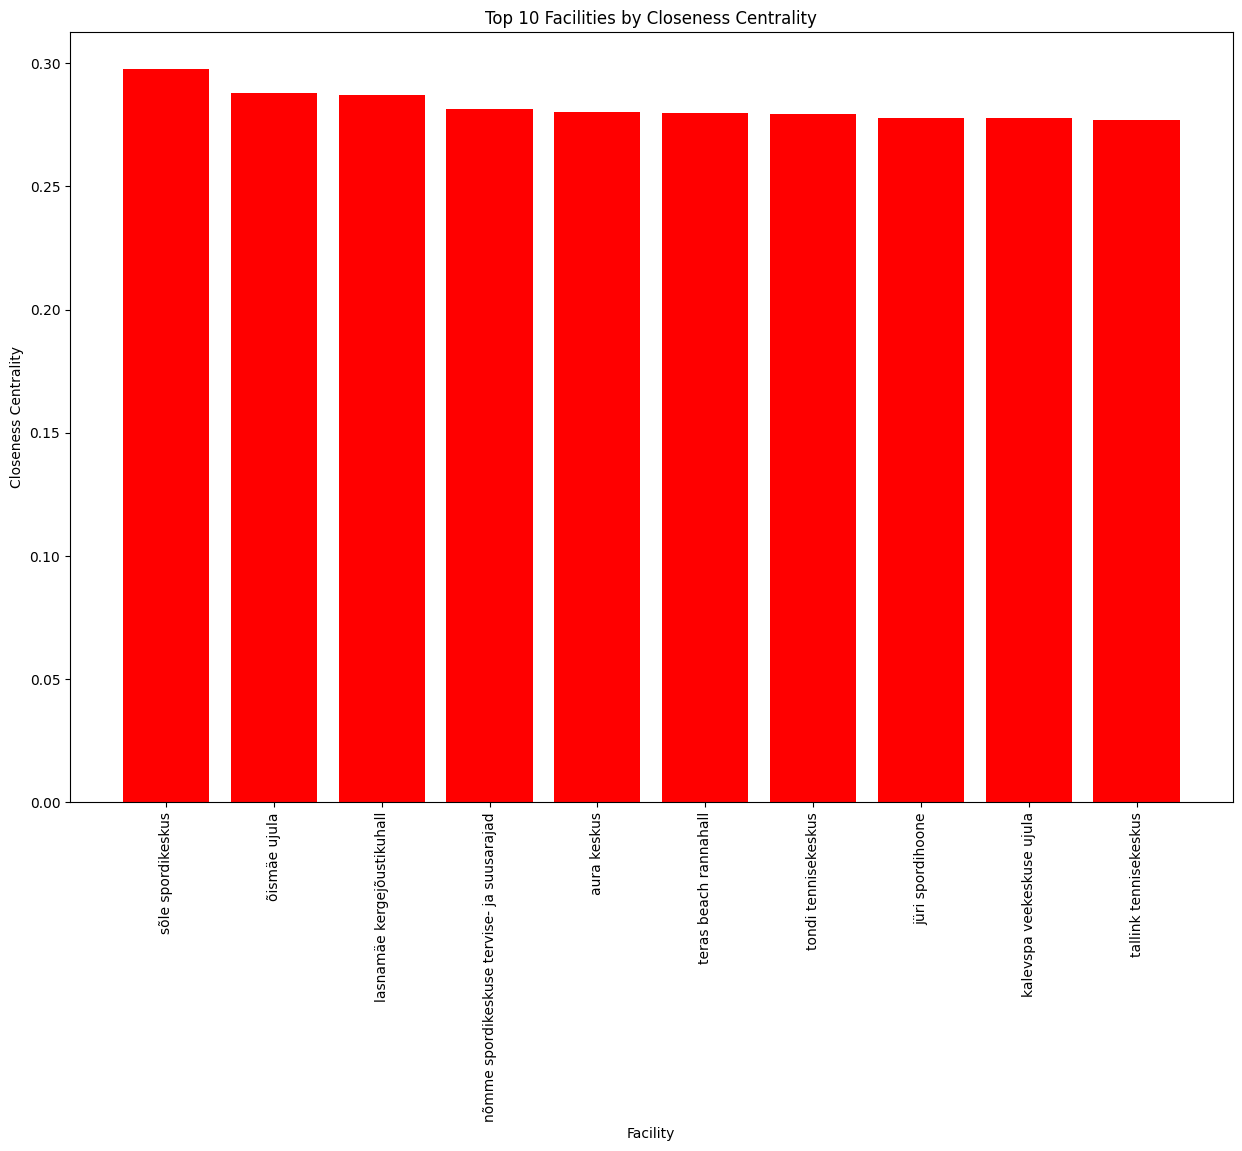

facility  closeness_centrality
405                            sõle spordikeskus              0.297776
229                                 õismäe ujula              0.287950
754                   lasnamäe kergejõustikuhall              0.287197
1055  nõmme spordikeskuse tervise- ja suusarajad              0.281314
399                                  aura keskus              0.280174
878                        teras beach rannahall              0.279671
941                          tondi tennisekeskus              0.279211
867                             jüri spordihoone              0.277964
724                    kalevspa veekeskuse ujula              0.277675
77                         tallink tennisekeskus              0.277139

In [15]:
# Extract the largest connected component of the graph
largest_cc = max(nx.connected_components(B), key=len)
B_largest_cc = B.subgraph(largest_cc).copy()

# Identify facility nodes in the largest connected component
facility_nodes_largest_cc = {n for n, d in B_largest_cc.nodes(data=True) if d['bipartite'] == 0}

# Calculate bipartite closeness centrality for facilities in the largest connected component
closeness_centrality_facilities = nx.bipartite.closeness_centrality(B_largest_cc, facility_nodes_largest_cc)

# Convert the results to a DataFrame with facility names
centrality_df = pd.DataFrame({
    'facility': [B_largest_cc.nodes[n]['label'] for n in facility_nodes_largest_cc],
    'closeness_centrality': [closeness_centrality_facilities[n] for n in facility_nodes_largest_cc]
})

# Sort the DataFrame by closeness centrality to find the most connected facilities
centrality_df = centrality_df.sort_values(by='closeness_centrality', ascending=False)

# Plot the centralities for visualization
plt.figure(figsize=(15, 10))
plt.bar(centrality_df['facility'][:10], centrality_df['closeness_centrality'][:10], color='red')
plt.xlabel('Facility')
plt.ylabel('Closeness Centrality')
plt.title('Top 10 Facilities by Closeness Centrality')
plt.xticks(rotation=90)
plt.show()

centrality_df.head(10)


### Community Detection

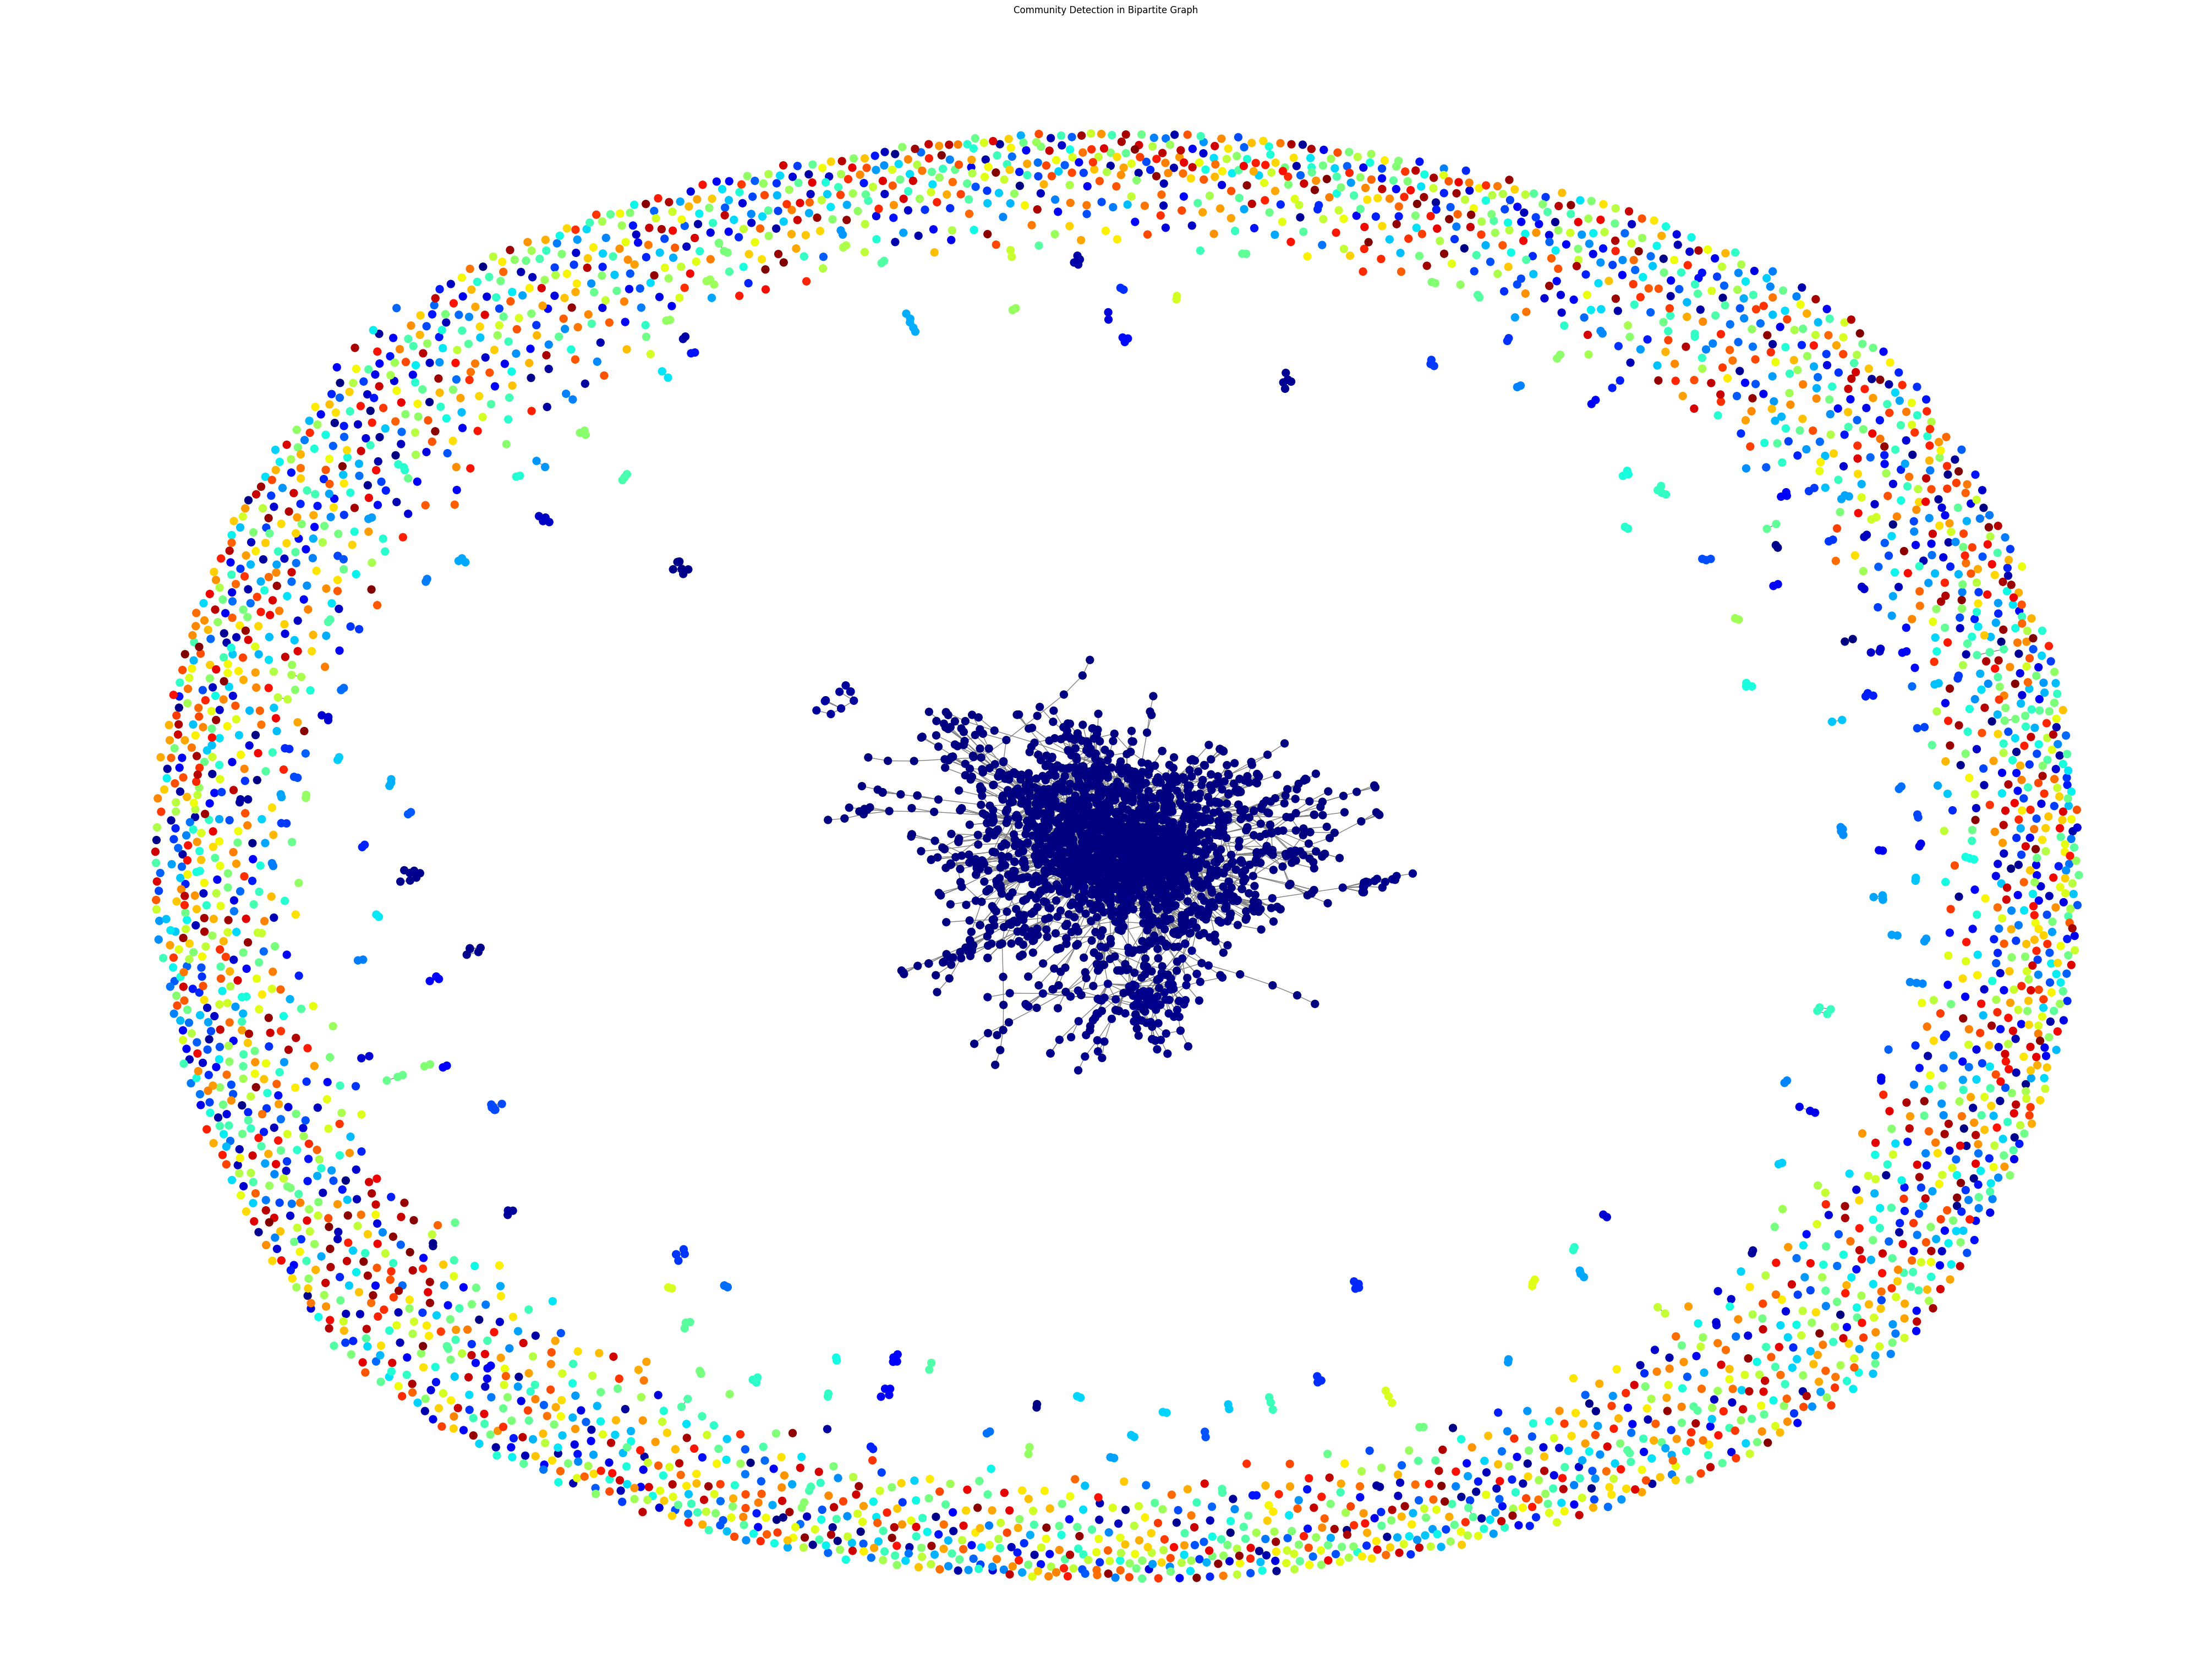

In [16]:
# Community detection using the Girvan-Newman algorithm
communities = girvan_newman(B)
top_level_communities = next(communities)
community_list = [list(community) for community in top_level_communities]

# Assign community labels to nodes
for i, community in enumerate(community_list):
    for node in community:
        B.nodes[node]['community'] = i

# Recalculate the layout position
pos = nx.spring_layout(B, seed=42)

# Ensure all nodes are in the layout
missing_nodes = set(B.nodes()) - set(pos.keys())
if missing_nodes:
    for node in missing_nodes:
        pos[node] = (0, 0)  # Assign a default position

# Visualize the communities with real names as labels
color_map = []
for node in B:
    if 'community' in B.nodes[node]:
        color_map.append(B.nodes[node]['community'])
    else:
        color_map.append(0)  # Default to a neutral color if no community is assigned

plt.figure(figsize=(40, 30))
nx.draw(B, pos, with_labels=False, node_size=100, font_size=6, node_color=color_map, edge_color='gray', cmap=plt.cm.jet)
plt.title("Community Detection in Bipartite Graph")
plt.show()

### Analysis of community detection results

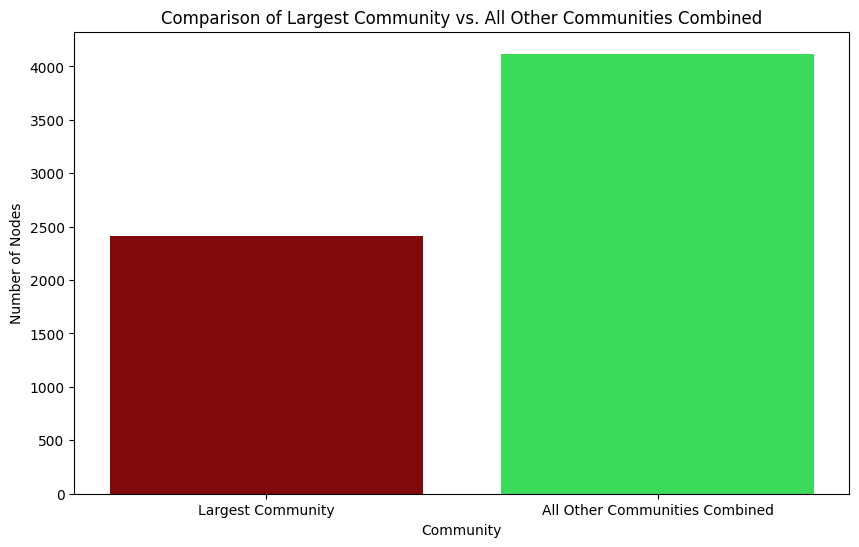

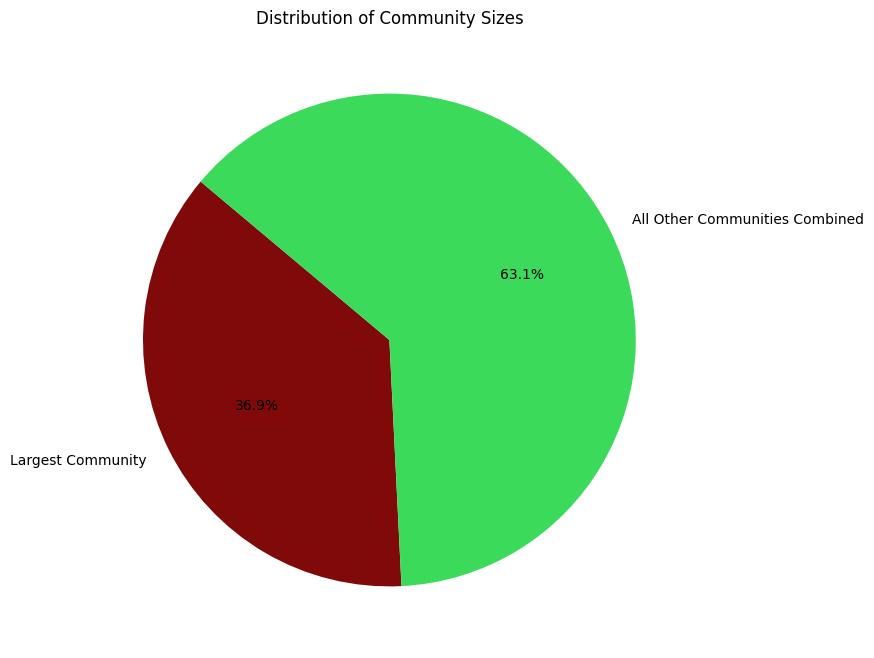

Number of unique communities: 3698
Number of nodes in the largest community: 2408
Number of nodes in the rest of the communities combined: 4119


In [17]:
# Find the number of unique communities
unique_communities = set(nx.get_node_attributes(B, 'community').values())
num_unique_communities = len(unique_communities)

# Find the number of nodes in each community
community_sizes = pd.Series(nx.get_node_attributes(B, 'community')).value_counts()

# Find the largest community
largest_community_size = community_sizes.max()
largest_community_id = community_sizes.idxmax()

# Calculate the sum of the sizes of the rest of the communities
rest_communities_size = community_sizes.drop(largest_community_id).sum()

# Plot the comparison between the largest community and all the rest combined
plt.figure(figsize=(10, 6))
plt.bar(['Largest Community', 'All Other Communities Combined'], 
        [largest_community_size, rest_communities_size], 
        color=['#800A0A', '#3BDA5A'])
plt.xlabel('Community')
plt.ylabel('Number of Nodes')
plt.title('Comparison of Largest Community vs. All Other Communities Combined')
plt.show()

# Plot the pie chart
plt.figure(figsize=(8, 8))
sizes = [largest_community_size, rest_communities_size]
labels = ['Largest Community', 'All Other Communities Combined']
colors = ['#800A0A', '#3BDA5A']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Community Sizes')
plt.show()

# Print the results
print(f"Number of unique communities: {num_unique_communities}")
print(f"Number of nodes in the largest community: {largest_community_size}")
print(f"Number of nodes in the rest of the communities combined: {rest_communities_size}")